In [1]:
# Import libraries
import pandas as pd
import numpy as np
import pickle
from scipy.sparse import save_npz, load_npz

# Feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS

# Model selection
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

# Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

print("✅ Đã import thành công!")

✅ Đã import thành công!


In [2]:
#  Load cleaned data
df = pd.read_csv('../data/cleaned_dataset.csv')

print("="*60)
print("DỮ LIỆU")
print("="*60)
print(f"Số lượng: {len(df):,}")
print(f"Toxic: {(df['label']==1).sum():,}")
print(f"Non-toxic: {(df['label']==0).sum():,}")
print(f"Tỷ lệ toxic: {(df['label']==1).mean()*100:.2f}%")


DỮ LIỆU
Số lượng: 164,062
Toxic: 16,748
Non-toxic: 147,314
Tỷ lệ toxic: 10.21%


XỬ LÝ STOPWORD

In [3]:
# Chuẩn bị stopwords
print("="*60)
print("CHUẨN BỊ STOPWORDS")
print("="*60)

# Stopwords tiếng Việt
vietnamese_stopwords = [
    'và', 'của', 'có', 'cho', 'tôi', 'mình', 'bạn', 'là', 'được',
    'đã', 'sẽ', 'đang', 'rất', 'thì', 'này', 'đó', 'với', 'để',
    'trong', 'ngoài', 'về', 'từ', 'đến', 'như', 'các', 'những',
    'khi', 'lúc', 'nếu', 'mà', 'nhưng', 'hay', 'hoặc', 'vì', 'nên'
]

# Kết hợp với stopwords tiếng Anh
english_stopwords = list(ENGLISH_STOP_WORDS) 
print(f"\nStopwords tiếng Việt: {vietnamese_stopwords[:10]}...")
print(f"Stopwords tiếng Anh: {list(ENGLISH_STOP_WORDS)[:10]}...")

CHUẨN BỊ STOPWORDS

Stopwords tiếng Việt: ['và', 'của', 'có', 'cho', 'tôi', 'mình', 'bạn', 'là', 'được', 'đã']...
Stopwords tiếng Anh: ['someone', 'seemed', 'onto', 'bottom', 'fifteen', 'please', 'whole', 'those', 'becoming', 'anything']...


DỮ LIỆU MẤT CÂN BẰNG CẢ VỀ NGÔN NGỮ LẪN NHÃN

In [4]:

# Lấy TẤT CẢ dữ liệu tiếng Anh
df_en = df[df['language'] == 'en'].copy()
# Lấy TẤT CẢ dữ liệu tiếng Việt
df_vi = df[df['language'] == 'vi'].copy()


print(f"   - df_en: {len(df_en)} mẫu")  
print(f"   - df_vi: {len(df_vi)} mẫu")   
print("--------------------------------------------------")

   - df_en: 159566 mẫu
   - df_vi: 4496 mẫu
--------------------------------------------------


In [5]:
#chia dữ liệu thành X và y
X_text_vi = df_vi['text']
y_vi = df_vi['label']
X_text_en = df_en['text']
y_en = df_en['label']
print(f"\n Đã chuẩn bị X_text_vi ({len(X_text_vi):,} docs) và y_vi ({len(y_vi):,} labels)")
print(f"\nĐã chuẩn bị X_text_en ({len(X_text_en):,} docs) và y_en ({len(y_en):,} labels)")


 Đã chuẩn bị X_text_vi (4,496 docs) và y_vi (4,496 labels)

Đã chuẩn bị X_text_en (159,566 docs) và y_en (159,566 labels)


Bag of Words Vectorization

In [6]:


# Vectorizer cho tiếng Việt
tfidf_vectorizer_vi = TfidfVectorizer(
    max_features=3000,       
    min_df=2, max_df=0.7,
    ngram_range=(1,2),
    stop_words=vietnamese_stopwords,
    token_pattern=r'\b\w+\b'
)

# Vectorizer cho tiếng Anh
tfidf_vectorizer_en = TfidfVectorizer(
    max_features=5000,
    min_df=2, max_df=0.8,
    ngram_range=(1,2),
    stop_words=english_stopwords,
    token_pattern=r'\b\w+\b'
)

In [7]:
# fit và transform dữ liệu
print("="*60); print("VECTORIZATION"); print("="*60)
print(f"🔄 Đang vectorize {len(df)} documents...")


# Fit và transform riêng
X_bow_vi = tfidf_vectorizer_vi.fit_transform(X_text_vi)
vocab_vi = tfidf_vectorizer_vi.get_feature_names_out()

X_bow_en = tfidf_vectorizer_en.fit_transform(X_text_en)
vocab_en = tfidf_vectorizer_en.get_feature_names_out()

print("✅ Hoàn thành!")
print(f" Đã tạo vectorizer tiếng Việt với {X_bow_vi.shape[1]} features.")
print(f" Đã tạo vectorizer tiếng Anh với {X_bow_en.shape[1]} features.")


VECTORIZATION
🔄 Đang vectorize 164062 documents...
✅ Hoàn thành!
 Đã tạo vectorizer tiếng Việt với 3000 features.
 Đã tạo vectorizer tiếng Anh với 5000 features.


In [8]:
print("="*60); print("KIỂM TRA VOCABULARY TIẾNG VIỆT"); print("="*60)
vocab_vi_list = list(vocab_vi)
print(f"Tổng số từ vựng (VI): {len(vocab_vi_list)} từ")
print("20 từ đầu tiên (VI):", vocab_vi_list[:20])
print("20 từ cuối cùng (VI):", vocab_vi_list[-20:])

print("\n"+"="*60); print("KIỂM TRA VOCABULARY TIẾNG ANH"); print("="*60)
vocab_en_list = list(vocab_en)
print(f"Tổng số từ vựng (EN): {len(vocab_en_list)} từ")
print("20 từ đầu tiên (EN):", vocab_en_list[:20])
print("20 từ cuối cùng (EN):", vocab_en_list[-20:])

# Kiểm tra stopwords có còn trong vocab không
stopword_check_vi = [w for w in vocab_vi_list if w in vietnamese_stopwords]
stopword_check_en = [w for w in vocab_en_list if w in english_stopwords]
print(f"\nStopwords còn trong vocab VI: {stopword_check_vi[:5]}...")
print(f"Stopwords còn trong vocab EN: {stopword_check_en[:5]}...")


KIỂM TRA VOCABULARY TIẾNG VIỆT
Tổng số từ vựng (VI): 3000 từ
20 từ đầu tiên (VI): ['0', '00', '1', '1 2', '1 bài', '1 cái', '1 dép', '1 hộp', '1 lần', '1 mùa', '1 ngày', '1 người', '1 năm', '1 trận', '10', '100', '11', '12', '14', '15']
20 từ cuối cùng (VI): ['ẻo', 'ối', 'ổn', 'ổn định', 'ổng', 'ở', 'ở lại', 'ở mỹ', 'ở nhà', 'ở phút', 'ở việt', 'ở vn', 'ở vòng', 'ở đâu', 'ở đây', 'ủa', 'ủng', 'ủng hộ', 'ức', 'ứng']

KIỂM TRA VOCABULARY TIẾNG ANH
Tổng số từ vựng (EN): 5000 từ
20 từ đầu tiên (EN): ['0', '0 0', '00', '000', '01', '02', '03', '04', '05', '06', '07', '08', '09', '1', '1 1', '1 2', '10', '100', '100 cellpadding', '100 style']
20 từ cuối cùng (EN): ['year', 'year old', 'years', 'years ago', 'years old', 'yellow', 'yes', 'yesterday', 'yo', 'york', 'york times', 'young', 'yourselfgo', 'yourselfgo fuck', 'youth', 'youtube', 'youtube com', 'ytmnd', 'z', 'zero']

Stopwords còn trong vocab VI: []...
Stopwords còn trong vocab EN: []...


In [9]:


# 1. ĐỊNH NGHĨA HÀM PHÂN TÍCH 
def analyze_top_words(X_bow, y, vocabulary, language_name=""):
    """
    Phân tích và in ra top 20 từ toxic và non-toxic
    từ một bộ vectorizer đã fit.
    """
    print("="*60)
    print(f"PHÂN TÍCH TOP WORDS CHO: {language_name.upper()}")
    print("="*60)

    # Tính tần suất cho từng nhóm
    toxic_mask = (y == 1)
    non_toxic_mask = (y == 0)

    # Đảm bảo y là numpy array để masking
    y_array = np.array(y)
    
    toxic_freq = np.asarray(X_bow[y_array == 1].sum(axis=0)).flatten()
    non_toxic_freq = np.asarray(X_bow[y_array == 0].sum(axis=0)).flatten()

    # Tạo DataFrame
    word_analysis = pd.DataFrame({
        'word': vocabulary,
        'toxic_freq': toxic_freq,
        'non_toxic_freq': non_toxic_freq,
        'total_freq': toxic_freq + non_toxic_freq
    })

    # Tính toxic ratio (Thêm +1 để tránh chia cho 0 nếu 1 từ chỉ xuất hiện 1 lần)
    word_analysis['toxic_ratio'] = word_analysis['toxic_freq'] / (
        word_analysis['total_freq'] + 1
    )
    
    # Lọc ra những từ có tần suất > 0 để phân tích có ý nghĩa hơn
    word_analysis = word_analysis[word_analysis['total_freq'] > 0]

    # Top toxic words
    print(f"\n🔴 Top 20 từ toxic nhất ({language_name}):")
    # Sắp xếp theo toxic_ratio VÀ total_freq để ưu tiên từ phổ biến
    top_toxic = word_analysis.sort_values(by=['toxic_ratio', 'total_freq'], ascending=False).head(20)
    for idx, row in top_toxic.iterrows():
        print(f"  • {row['word']}: {row['toxic_ratio']*100:.1f}% toxic "
              f"(toxic={int(row['toxic_freq'])}, non-toxic={int(row['non_toxic_freq'])})")

    # Top non-toxic words
    print(f"\n🟢 Top 20 từ non-toxic nhất ({language_name}):")
    # Sắp xếp theo toxic_ratio (tăng dần) VÀ total_freq (giảm dần)
    top_non_toxic = word_analysis.sort_values(by=['toxic_ratio', 'total_freq'], ascending=[True, False]).head(20)
    for idx, row in top_non_toxic.iterrows():
        print(f"  • {row['word']}: {row['toxic_ratio']*100:.1f}% toxic "
              f"(toxic={int(row['toxic_freq'])}, non-toxic={int(row['non_toxic_freq'])})")
    print("\n")



# 2. GỌI HÀM PHÂN TÍCH

# Phân tích cho model Tiếng Anh
try:
    analyze_top_words(
        X_bow=X_bow_en, 
        y=y_en, 
        vocabulary=vocab_en_list, 
        language_name="Tiếng Anh (EN)"
    )
except NameError:
    print("LỖI: Hãy đảm bảo bạn đã chạy cell huấn luyện model EN (tạo ra X_en_bow, y_en, vectorizer_en)")
except Exception as e:
    print(f"Lỗi khi phân tích EN: {e}")


# Phân tích cho model Tiếng Việt
try:
    analyze_top_words(
        X_bow=X_bow_vi,  
        y=y_vi,         
        vocabulary=vocab_vi_list, 
        language_name="Tiếng Việt (VI)"
    )
except NameError:
    print("LỖI: Hãy đảm bảo bạn đã chạy cell huấn luyện model VI (tạo ra X_vi_bow, y_vi, vectorizer_vi)")
except Exception as e:
    print(f"Lỗi khi phân tích VI: {e}")

PHÂN TÍCH TOP WORDS CHO: TIẾNG ANH (EN)

🔴 Top 20 từ toxic nhất (Tiếng Anh (EN)):
  • fuck: 99.0% toxic (toxic=873, non-toxic=7)
  • fucking: 98.7% toxic (toxic=530, non-toxic=5)
  • faggot: 98.5% toxic (toxic=181, non-toxic=1)
  • fuckin: 98.3% toxic (toxic=68, non-toxic=0)
  • fuck fuck: 98.3% toxic (toxic=58, non-toxic=0)
  • bitch: 98.3% toxic (toxic=266, non-toxic=3)
  • fucker: 98.2% toxic (toxic=69, non-toxic=0)
  • suck dick: 97.7% toxic (toxic=43, non-toxic=0)
  • fuck u: 97.4% toxic (toxic=37, non-toxic=0)
  • cock: 97.3% toxic (toxic=114, non-toxic=2)
  • cunt: 97.2% toxic (toxic=184, non-toxic=4)
  • piece shit: 97.0% toxic (toxic=73, non-toxic=1)
  • asshole: 96.9% toxic (toxic=214, non-toxic=5)
  • cocksucker: 96.3% toxic (toxic=26, non-toxic=0)
  • suck: 96.3% toxic (toxic=255, non-toxic=8)
  • eat shit: 96.0% toxic (toxic=25, non-toxic=0)
  • shut fuck: 95.9% toxic (toxic=29, non-toxic=0)
  • suck cock: 95.7% toxic (toxic=22, non-toxic=0)
  • bastard: 95.3% toxic (toxic

CHIA DỮ LIỆU ĐỂ TRAN VÀ TEST

In [10]:
#  CHIA DỮ LIỆU THÀNH TRAIN/VALIDATION/TEST
print("\n--- Section: CHIA TẬP TRAIN/VALIDATION/TEST ---")

# Hàm in thông tin phân phối nhãn
def print_label_distribution(X, y, set_name):
    print(f"\n{set_name}:")
    print(f"  - Số mẫu: {X.shape[0]:,}")
    print(f"  - Toxic: {(y == 1).sum():,} ({(y == 1).mean()*100:.2f}%)")
    print(f"  - Non-toxic: {(y == 0).sum():,} ({(y == 0).mean()*100:.2f}%)")

# (1) Tiếng Anh: Chia train/validation/test
X_en_temp, X_en_test, y_en_temp, y_en_test = train_test_split(
    X_bow_en, y_en, test_size=0.2, random_state=42, stratify=y_en
)
X_en_train, X_en_val, y_en_train, y_en_val = train_test_split(
    X_en_temp, y_en_temp, test_size=0.25, random_state=42, stratify=y_en_temp
)  # 0.25 * 0.8 = 0.2 (validation)

print("\nTiếng Anh (EN):")
print_label_distribution(X_en_train, y_en_train, "Train")
print_label_distribution(X_en_val, y_en_val, "Validation")
print_label_distribution(X_en_test, y_en_test, "Test")

# (2) Tiếng Việt: Chia train/validation/test
X_vi_temp, X_vi_test, y_vi_temp, y_vi_test = train_test_split(
    X_bow_vi, y_vi, test_size=0.2, random_state=42, stratify=y_vi
)
X_vi_train, X_vi_val, y_vi_train, y_vi_val = train_test_split(
    X_vi_temp, y_vi_temp, test_size=0.25, random_state=42, stratify=y_vi_temp
)

print("\nTiếng Việt (VI):")
print_label_distribution(X_vi_train, y_vi_train, "Train")
print_label_distribution(X_vi_val, y_vi_val, "Validation")
print_label_distribution(X_vi_test, y_vi_test, "Test")


--- Section: CHIA TẬP TRAIN/VALIDATION/TEST ---

Tiếng Anh (EN):

Train:
  - Số mẫu: 95,739
  - Toxic: 9,734 (10.17%)
  - Non-toxic: 86,005 (89.83%)

Validation:
  - Số mẫu: 31,913
  - Toxic: 3,244 (10.17%)
  - Non-toxic: 28,669 (89.83%)

Test:
  - Số mẫu: 31,914
  - Toxic: 3,245 (10.17%)
  - Non-toxic: 28,669 (89.83%)

Tiếng Việt (VI):

Train:
  - Số mẫu: 2,697
  - Toxic: 315 (11.68%)
  - Non-toxic: 2,382 (88.32%)

Validation:
  - Số mẫu: 899
  - Toxic: 105 (11.68%)
  - Non-toxic: 794 (88.32%)

Test:
  - Số mẫu: 900
  - Toxic: 105 (11.67%)
  - Non-toxic: 795 (88.33%)



TÌM SIÊU THAM SỐ VỚI GRIDSEARCHCV VÀ VẼ BIỂU ĐỒ

🔄 Xử lý LinearSVC (EN)...


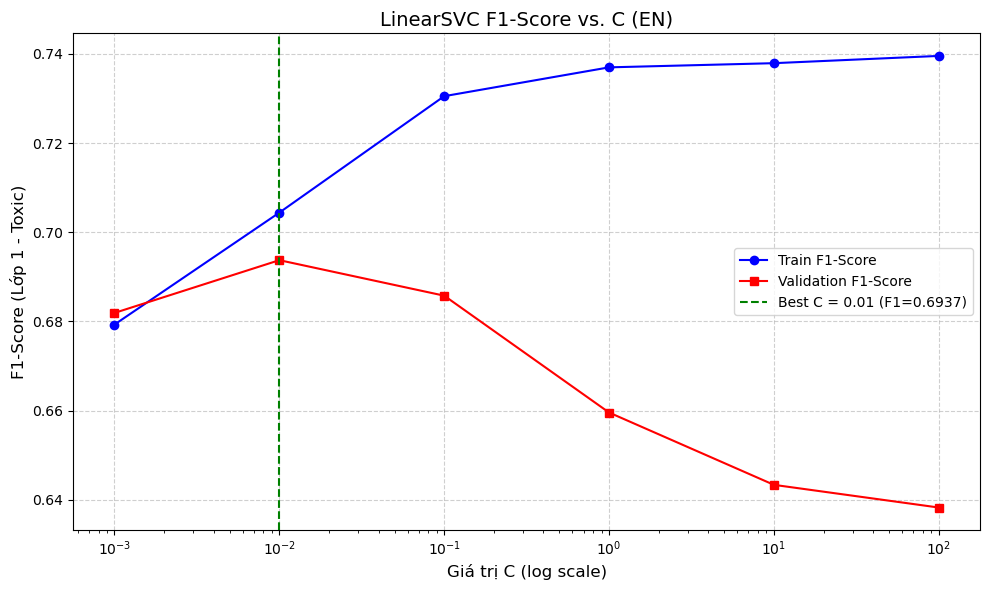


🔄 Xử lý Naive Bayes (EN)...


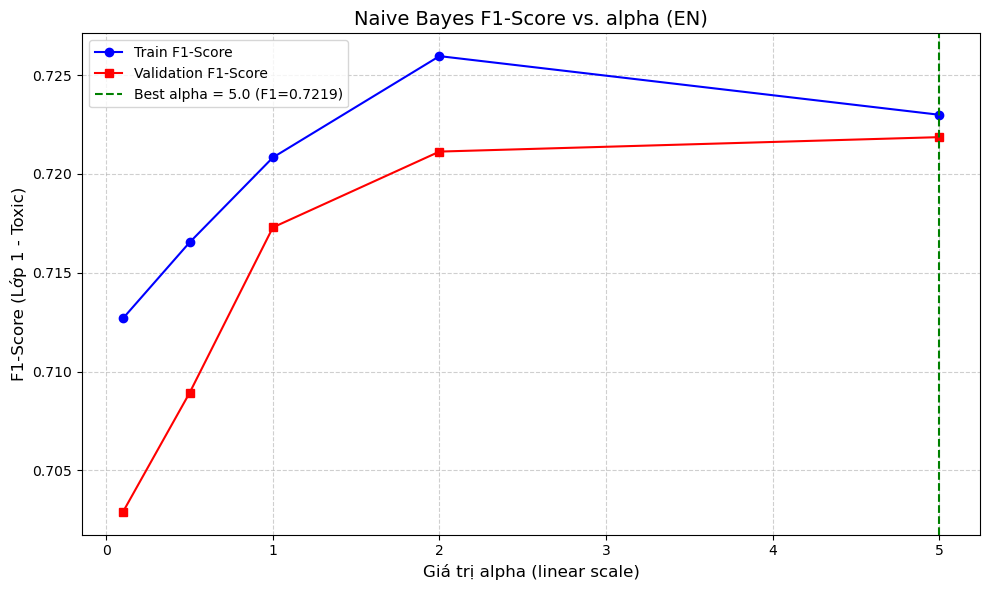


🔄 Xử lý Logistic Regression (EN)...

🔄 Xử lý LinearSVC (VI)...


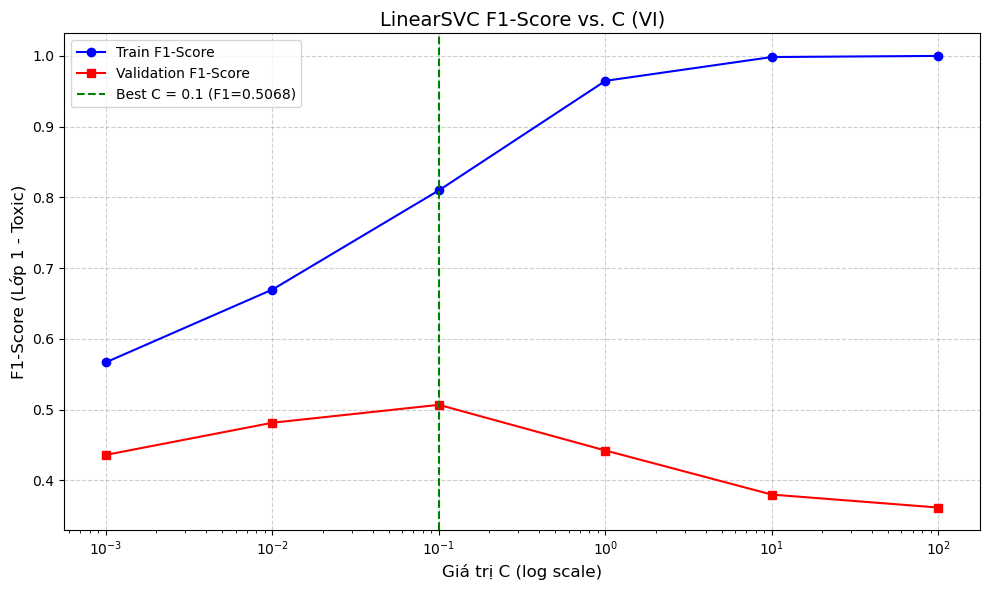


🔄 Xử lý Naive Bayes (VI)...


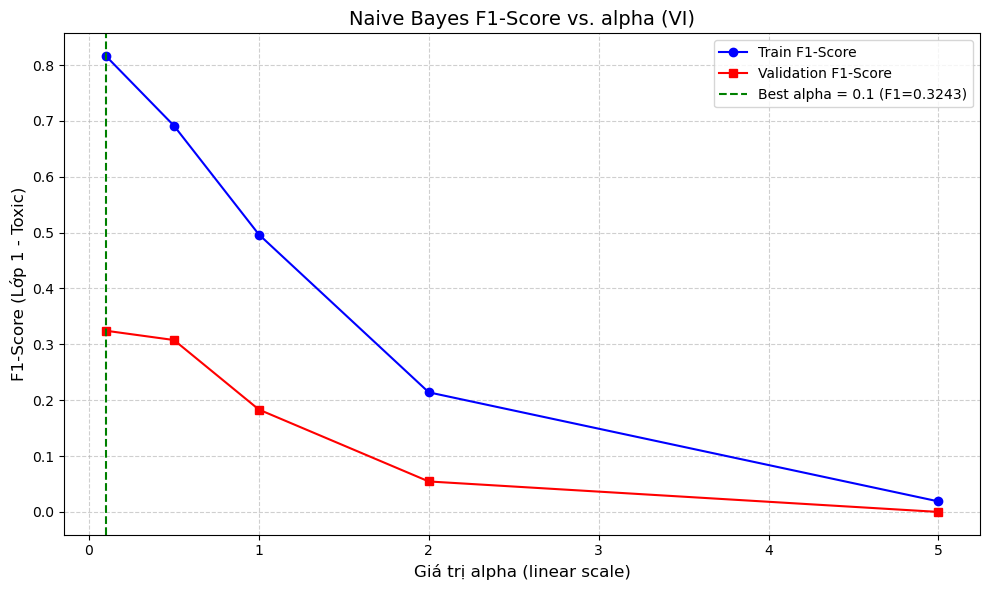


🔄 Xử lý Logistic Regression (VI)...


In [ ]:
#  TÌM SIÊU THAM SỐ VỚI GRIDSEARCHCV VÀ VẼ BIỂU ĐỒ
print("\n" + "="*60)
print("TÌM SIÊU THAM SỐ VỚI GRIDSEARCHCV VÀ VẼ BIỂU ĐỒ")
print("="*60)

# Hàm vẽ biểu đồ F1-Score cho một danh sách giá trị siêu tham số
def plot_f1_vs_param(X_train, y_train, X_val, y_val, param_values, model_type, param_name, language):
    train_f1s = []
    val_f1s = []
    class_weight = 'balanced'
    
    for param in param_values:
        if model_type == 'LinearSVC':
            model = LinearSVC(C=param, max_iter=5000, random_state=42, class_weight=class_weight)
        elif model_type == 'Naive Bayes':
            model = MultinomialNB(alpha=param, class_prior=[0.7, 0.3])  # Sử dụng class_prior
        elif model_type == 'Logistic Regression':
            model = LogisticRegression(max_iter=10000, random_state=42, class_weight=class_weight, solver='lbfgs')  # Không tối ưu C
        
        model.fit(X_train, y_train)
        
        # F1 trên tập train
        y_train_pred = model.predict(X_train)
        train_f1s.append(f1_score(y_train, y_train_pred))
        
        # F1 trên tập validation
        y_val_pred = model.predict(X_val)
        val_f1s.append(f1_score(y_val, y_val_pred))
    
    # Tìm giá trị tốt nhất dựa trên F1 của tập validation (trừ Logistic Regression)
    if model_type != 'Logistic Regression':
        best_param = param_values[np.argmax(val_f1s)]
        best_val_f1 = max(val_f1s)
    else:
        best_param = None  # Không áp dụng tối ưu cho Logistic Regression
        best_val_f1 = val_f1s[0]  # Lấy F1 với tham số mặc định
    
    # Vẽ biểu đồ (chỉ cho LinearSVC và Naive Bayes)
    if model_type != 'Logistic Regression':
        plt.figure(figsize=(10, 6))
        plt.plot(param_values, train_f1s, 'o-', label='Train F1-Score', color='blue')
        plt.plot(param_values, val_f1s, 's-', label='Validation F1-Score', color='red')
        plt.axvline(best_param, color='green', linestyle='--', label=f'Best {param_name} = {best_param} (F1={best_val_f1:.4f})')
        plt.xscale('log' if model_type == 'LinearSVC' else 'linear')
        plt.title(f'{model_type} F1-Score vs. {param_name} ({language})', fontsize=14)
        plt.xlabel(f'Giá trị {param_name} ({("log scale" if model_type == "LinearSVC" else "linear scale")})', fontsize=12)
        plt.ylabel('F1-Score (Lớp 1 - Toxic)', fontsize=12)
        plt.legend(fontsize=10)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()
    
    # Huấn luyện lại với giá trị tốt nhất (hoặc mặc định cho Logistic Regression)
    if model_type == 'LinearSVC':
        best_model = LinearSVC(C=best_param, max_iter=5000, random_state=42, class_weight=class_weight)
    elif model_type == 'Naive Bayes':
        best_model = MultinomialNB(alpha=best_param, class_prior=[0.7, 0.3])
    elif model_type == 'Logistic Regression':
        best_model = LogisticRegression(max_iter=10000, random_state=42, class_weight=class_weight, solver='lbfgs')
    best_model.fit(X_train, y_train)
    return best_model, {param_name: best_param} if model_type != 'Logistic Regression' else {'default': True}

# Định nghĩa phạm vi siêu tham số
param_ranges = {
    'LinearSVC': {'param_name': 'C', 'values': [0.001, 0.01, 0.1, 1, 10, 100]},
    'Naive Bayes': {'param_name': 'alpha', 'values': [0.1, 0.5, 1.0, 2.0, 5.0]},
    'Logistic Regression': {'param_name': 'default', 'values': [1]} 
}

# (1) Tiếng Anh
best_models_en = {}
for model_name in ['LinearSVC', 'Naive Bayes', 'Logistic Regression']:
    print(f"\n🔄 Xử lý {model_name} (EN)...")
    best_model, best_params = plot_f1_vs_param(
        X_en_train, y_en_train, X_en_val, y_en_val,
        param_ranges[model_name]['values'], model_name, param_ranges[model_name]['param_name'], 'EN'
    )
    best_models_en[model_name] = {'model': best_model, 'params': best_params}

# (2) Tiếng Việt
best_models_vi = {}
for model_name in ['LinearSVC', 'Naive Bayes', 'Logistic Regression']:
    print(f"\n🔄 Xử lý {model_name} (VI)...")
    best_model, best_params = plot_f1_vs_param(
        X_vi_train, y_vi_train, X_vi_val, y_vi_val,
        param_ranges[model_name]['values'], model_name, param_ranges[model_name]['param_name'], 'VI'
    )
    best_models_vi[model_name] = {'model': best_model, 'params': best_params}

1.NAIVE BAYES


HUẤN LUYỆN NAIVE BAYES TIẾNG ANH


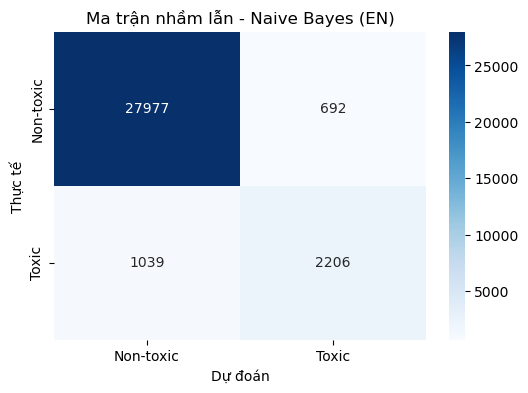

📊 Kết quả:
  • Train Accuracy: 94.73%
  • Test Accuracy: 94.58%
  • Precision: 76.12%
  • Recall: 67.98%
  • F1-Score: 71.82%


In [12]:
#  HUẤN LUYỆN NAIVE BAYES TIẾNG ANH


print("\n" + "="*60)
print("HUẤN LUYỆN NAIVE BAYES TIẾNG ANH")
print("="*60)

# Lấy mô hình
model_nb_en = best_models_en['Naive Bayes']['model']

# Huấn luyện và dự đoán
model_nb_en.fit(X_en_train, y_en_train)
y_pred_train = model_nb_en.predict(X_en_train)
y_pred_test = model_nb_en.predict(X_en_test)

# Tính ma trận nhầm lẫn
cm = confusion_matrix(y_en_test, y_pred_test)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-toxic', 'Toxic'], yticklabels=['Non-toxic', 'Toxic'])
plt.title('Ma trận nhầm lẫn - Naive Bayes (EN)')
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.show()

# Tính các chỉ số
train_acc = accuracy_score(y_en_train, y_pred_train)
test_acc = accuracy_score(y_en_test, y_pred_test)
precision = precision_score(y_en_test, y_pred_test)
recall = recall_score(y_en_test, y_pred_test)
f1 = f1_score(y_en_test, y_pred_test)

print(f"📊 Kết quả:")
print(f"  • Train Accuracy: {train_acc*100:.2f}%")
print(f"  • Test Accuracy: {test_acc*100:.2f}%")
print(f"  • Precision: {precision*100:.2f}%")
print(f"  • Recall: {recall*100:.2f}%")
print(f"  • F1-Score: {f1*100:.2f}%")


HUẤN LUYỆN NAIVE BAYES TIẾNG VIỆT


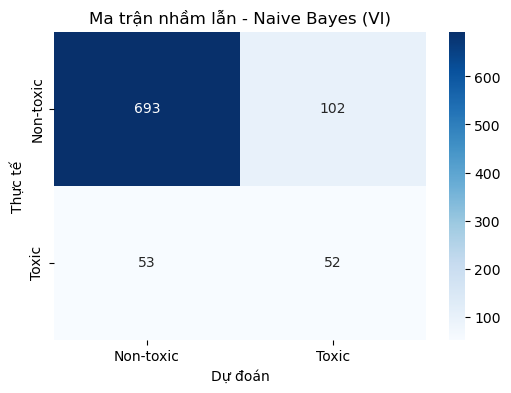

📊 Kết quả:
  • Train Accuracy: 95.37%
  • Test Accuracy: 82.78%
  • Precision: 33.77%
  • Recall: 49.52%
  • F1-Score: 40.15%


In [13]:
# : HUẤN LUYỆN NAIVE BAYES TIẾNG VIỆT

print("\n" + "="*60)
print("HUẤN LUYỆN NAIVE BAYES TIẾNG VIỆT")
print("="*60)

# Lấy mô hình từ Cell 11
model_nb_vi = best_models_vi['Naive Bayes']['model']

# Huấn luyện và dự đoán
model_nb_vi.fit(X_vi_train, y_vi_train)
y_pred_train = model_nb_vi.predict(X_vi_train)
y_pred_test = model_nb_vi.predict(X_vi_test)

# Tính ma trận nhầm lẫn
cm = confusion_matrix(y_vi_test, y_pred_test)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-toxic', 'Toxic'], yticklabels=['Non-toxic', 'Toxic'])
plt.title('Ma trận nhầm lẫn - Naive Bayes (VI)')
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.show()

# Tính các chỉ số
train_acc = accuracy_score(y_vi_train, y_pred_train)
test_acc = accuracy_score(y_vi_test, y_pred_test)
precision = precision_score(y_vi_test, y_pred_test)
recall = recall_score(y_vi_test, y_pred_test)
f1 = f1_score(y_vi_test, y_pred_test)

print(f"📊 Kết quả:")
print(f"  • Train Accuracy: {train_acc*100:.2f}%")
print(f"  • Test Accuracy: {test_acc*100:.2f}%")
print(f"  • Precision: {precision*100:.2f}%")
print(f"  • Recall: {recall*100:.2f}%")
print(f"  • F1-Score: {f1*100:.2f}%")

MODEL 2. LOGISTIC REGRESSION 


HUẤN LUYỆN LOGISTIC REGRESSION TIẾNG ANH


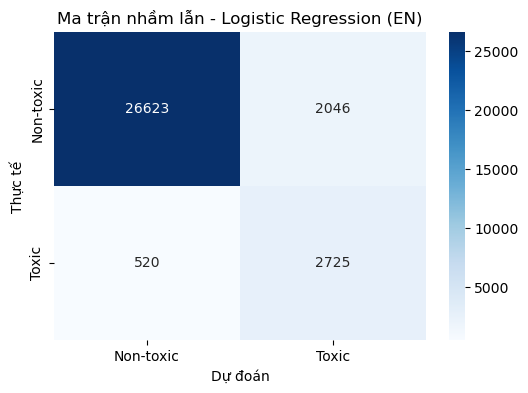

📊 Kết quả:
  • Train Accuracy: 93.02%
  • Test Accuracy: 91.96%
  • Precision: 57.12%
  • Recall: 83.98%
  • F1-Score: 67.99%


In [14]:
# Cell 18: HUẤN LUYỆN LOGISTIC REGRESSION TIẾNG ANH

print("\n" + "="*60)
print("HUẤN LUYỆN LOGISTIC REGRESSION TIẾNG ANH")
print("="*60)

# Lấy mô hình từ Cell 11
model_lr_en = best_models_en['Logistic Regression']['model']

# Huấn luyện và dự đoán
model_lr_en.fit(X_en_train, y_en_train)
y_pred_train = model_lr_en.predict(X_en_train)
y_pred_test = model_lr_en.predict(X_en_test)

# Tính ma trận nhầm lẫn
cm = confusion_matrix(y_en_test, y_pred_test)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-toxic', 'Toxic'], yticklabels=['Non-toxic', 'Toxic'])
plt.title('Ma trận nhầm lẫn - Logistic Regression (EN)')
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.show()

# Tính các chỉ số
train_acc = accuracy_score(y_en_train, y_pred_train)
test_acc = accuracy_score(y_en_test, y_pred_test)
precision = precision_score(y_en_test, y_pred_test)
recall = recall_score(y_en_test, y_pred_test)
f1 = f1_score(y_en_test, y_pred_test)

print(f"📊 Kết quả:")
print(f"  • Train Accuracy: {train_acc*100:.2f}%")
print(f"  • Test Accuracy: {test_acc*100:.2f}%")
print(f"  • Precision: {precision*100:.2f}%")
print(f"  • Recall: {recall*100:.2f}%")
print(f"  • F1-Score: {f1*100:.2f}%")


HUẤN LUYỆN LOGISTIC REGRESSION TIẾNG VIỆT


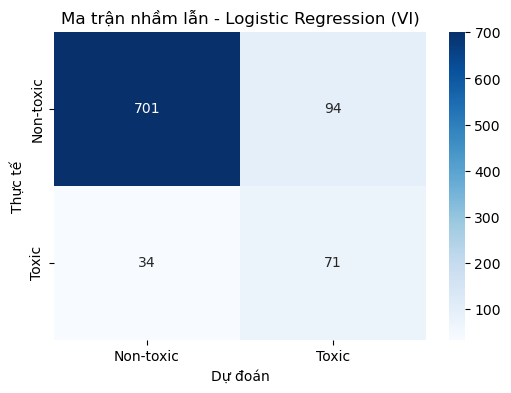

📊 Kết quả:
  • Train Accuracy: 95.03%
  • Test Accuracy: 85.78%
  • Precision: 43.03%
  • Recall: 67.62%
  • F1-Score: 52.59%


In [15]:
#  HUẤN LUYỆN LOGISTIC REGRESSION TIẾNG VIỆT


print("\n" + "="*60)
print("HUẤN LUYỆN LOGISTIC REGRESSION TIẾNG VIỆT")
print("="*60)

# Lấy mô hình từ Cell 11
model_lr_vi = best_models_vi['Logistic Regression']['model']

# Huấn luyện và dự đoán
model_lr_vi.fit(X_vi_train, y_vi_train)
y_pred_train = model_lr_vi.predict(X_vi_train)
y_pred_test = model_lr_vi.predict(X_vi_test)

# Tính ma trận nhầm lẫn
cm = confusion_matrix(y_vi_test, y_pred_test)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-toxic', 'Toxic'], yticklabels=['Non-toxic', 'Toxic'])
plt.title('Ma trận nhầm lẫn - Logistic Regression (VI)')
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.show()

# Tính các chỉ số
train_acc = accuracy_score(y_vi_train, y_pred_train)
test_acc = accuracy_score(y_vi_test, y_pred_test)
precision = precision_score(y_vi_test, y_pred_test)
recall = recall_score(y_vi_test, y_pred_test)
f1 = f1_score(y_vi_test, y_pred_test)

print(f"📊 Kết quả:")
print(f"  • Train Accuracy: {train_acc*100:.2f}%")
print(f"  • Test Accuracy: {test_acc*100:.2f}%")
print(f"  • Precision: {precision*100:.2f}%")
print(f"  • Recall: {recall*100:.2f}%")
print(f"  • F1-Score: {f1*100:.2f}%")

MODEL 3. SVM


HUẤN LUYỆN LINEARSVC TIẾNG ANH


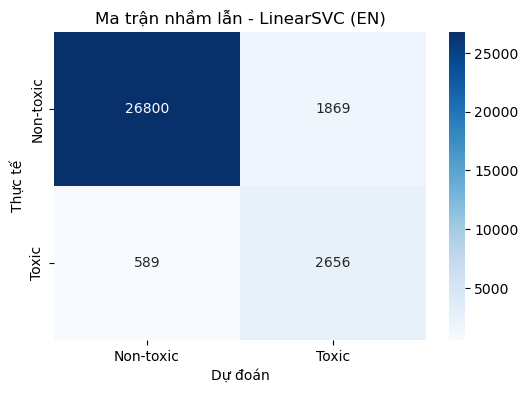

📊 Kết quả:
  • Train Accuracy: 92.86%
  • Test Accuracy: 92.30%
  • Precision: 58.70%
  • Recall: 81.85%
  • F1-Score: 68.37%


In [16]:
# HUẤN LUYỆN LINEARSVC TIẾNG ANH


print("\n" + "="*60)
print("HUẤN LUYỆN LINEARSVC TIẾNG ANH")
print("="*60)

# Lấy mô hình từ Cell 11
model_svm_en = best_models_en['LinearSVC']['model']

# Huấn luyện và dự đoán
model_svm_en.fit(X_en_train, y_en_train)
y_pred_train = model_svm_en.predict(X_en_train)
y_pred_test = model_svm_en.predict(X_en_test)

# Tính ma trận nhầm lẫn
cm = confusion_matrix(y_en_test, y_pred_test)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-toxic', 'Toxic'], yticklabels=['Non-toxic', 'Toxic'])
plt.title('Ma trận nhầm lẫn - LinearSVC (EN)')
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.show()

# Tính các chỉ số
train_acc = accuracy_score(y_en_train, y_pred_train)
test_acc = accuracy_score(y_en_test, y_pred_test)
precision = precision_score(y_en_test, y_pred_test)
recall = recall_score(y_en_test, y_pred_test)
f1 = f1_score(y_en_test, y_pred_test)

print(f"📊 Kết quả:")
print(f"  • Train Accuracy: {train_acc*100:.2f}%")
print(f"  • Test Accuracy: {test_acc*100:.2f}%")
print(f"  • Precision: {precision*100:.2f}%")
print(f"  • Recall: {recall*100:.2f}%")
print(f"  • F1-Score: {f1*100:.2f}%")


HUẤN LUYỆN LINEARSVC TIẾNG VIỆT


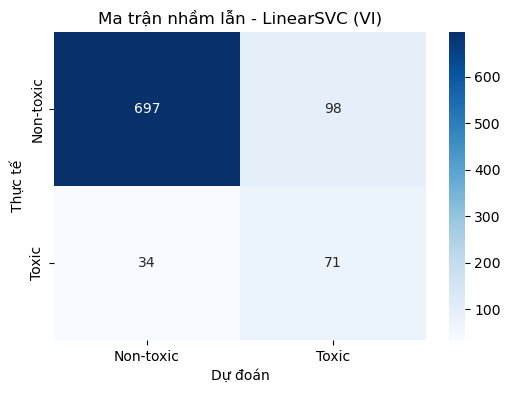

📊 Kết quả:
  • Train Accuracy: 94.66%
  • Test Accuracy: 85.33%
  • Precision: 42.01%
  • Recall: 67.62%
  • F1-Score: 51.82%


In [17]:
#  HUẤN LUYỆN LINEARSVC TIẾNG VIỆT


print("\n" + "="*60)
print("HUẤN LUYỆN LINEARSVC TIẾNG VIỆT")
print("="*60)

# Lấy mô hình từ Cell 11
model_svm_vi = best_models_vi['LinearSVC']['model']

# Huấn luyện và dự đoán
model_svm_vi.fit(X_vi_train, y_vi_train)
y_pred_train = model_svm_vi.predict(X_vi_train)
y_pred_test = model_svm_vi.predict(X_vi_test)

# Tính ma trận nhầm lẫn
cm = confusion_matrix(y_vi_test, y_pred_test)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-toxic', 'Toxic'], yticklabels=['Non-toxic', 'Toxic'])
plt.title('Ma trận nhầm lẫn - LinearSVC (VI)')
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.show()

# Tính các chỉ số
train_acc = accuracy_score(y_vi_train, y_pred_train)
test_acc = accuracy_score(y_vi_test, y_pred_test)
precision = precision_score(y_vi_test, y_pred_test)
recall = recall_score(y_vi_test, y_pred_test)
f1 = f1_score(y_vi_test, y_pred_test)

print(f"📊 Kết quả:")
print(f"  • Train Accuracy: {train_acc*100:.2f}%")
print(f"  • Test Accuracy: {test_acc*100:.2f}%")
print(f"  • Precision: {precision*100:.2f}%")
print(f"  • Recall: {recall*100:.2f}%")
print(f"  • F1-Score: {f1*100:.2f}%")

In [18]:
# Cell 14: SO SÁNH TẤT CẢ MODELS
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("\n" + "="*60)
print("SO SÁNH TẤT CẢ MODELS")
print("="*60)

# Hàm đánh giá mô hình với dữ liệu đã huấn luyện
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    return {
        'model_name': model_name,
        'train_acc': accuracy_score(y_train, y_pred_train) * 100,
        'test_acc': accuracy_score(y_test, y_pred_test) * 100,
        'precision': precision_score(y_test, y_pred_test) * 100,
        'recall': recall_score(y_test, y_pred_test) * 100,
        'f1': f1_score(y_test, y_pred_test) * 100
    }

# Thu thập kết quả từ các mô hình đã huấn luyện trong Cell 11
results = [
    evaluate_model(best_models_en['Naive Bayes']['model'], X_en_train, y_en_train, X_en_test, y_en_test, 'Naive Bayes (EN)'),
    evaluate_model(best_models_en['Logistic Regression']['model'], X_en_train, y_en_train, X_en_test, y_en_test, 'Logistic Regression (EN)'),
    evaluate_model(best_models_en['LinearSVC']['model'], X_en_train, y_en_train, X_en_test, y_en_test, 'LinearSVC (EN)'),
    evaluate_model(best_models_vi['Naive Bayes']['model'], X_vi_train, y_vi_train, X_vi_test, y_vi_test, 'Naive Bayes (VI)'),
    evaluate_model(best_models_vi['Logistic Regression']['model'], X_vi_train, y_vi_train, X_vi_test, y_vi_test, 'Logistic Regression (VI)'),
    evaluate_model(best_models_vi['LinearSVC']['model'], X_vi_train, y_vi_train, X_vi_test, y_vi_test, 'LinearSVC (VI)')
]

# Tạo DataFrame
df_comparison = pd.DataFrame(results)
df_comparison = df_comparison.sort_values('f1', ascending=False)

print("\n📊 Bảng so sánh đầy đủ:")
print(df_comparison[['model_name', 'train_acc', 'test_acc', 'precision', 'recall', 'f1']].to_string(
    index=False, 
    formatters={
        'train_acc': '{:.2f}%'.format,
        'test_acc': '{:.2f}%'.format,
        'precision': '{:.2f}%'.format,
        'recall': '{:.2f}%'.format,
        'f1': '{:.2f}%'.format
    }
))


SO SÁNH TẤT CẢ MODELS

📊 Bảng so sánh đầy đủ:
              model_name train_acc test_acc precision recall     f1
        Naive Bayes (EN)    94.73%   94.58%    76.12% 67.98% 71.82%
          LinearSVC (EN)    92.86%   92.30%    58.70% 81.85% 68.37%
Logistic Regression (EN)    93.02%   91.96%    57.12% 83.98% 67.99%
Logistic Regression (VI)    95.03%   85.78%    43.03% 67.62% 52.59%
          LinearSVC (VI)    94.66%   85.33%    42.01% 67.62% 51.82%
        Naive Bayes (VI)    95.37%   82.78%    33.77% 49.52% 40.15%



TRỰC QUAN HÓA BÀNG SO SÁNH DƯỚI DẠNG BIỂU ĐỒ CỘT


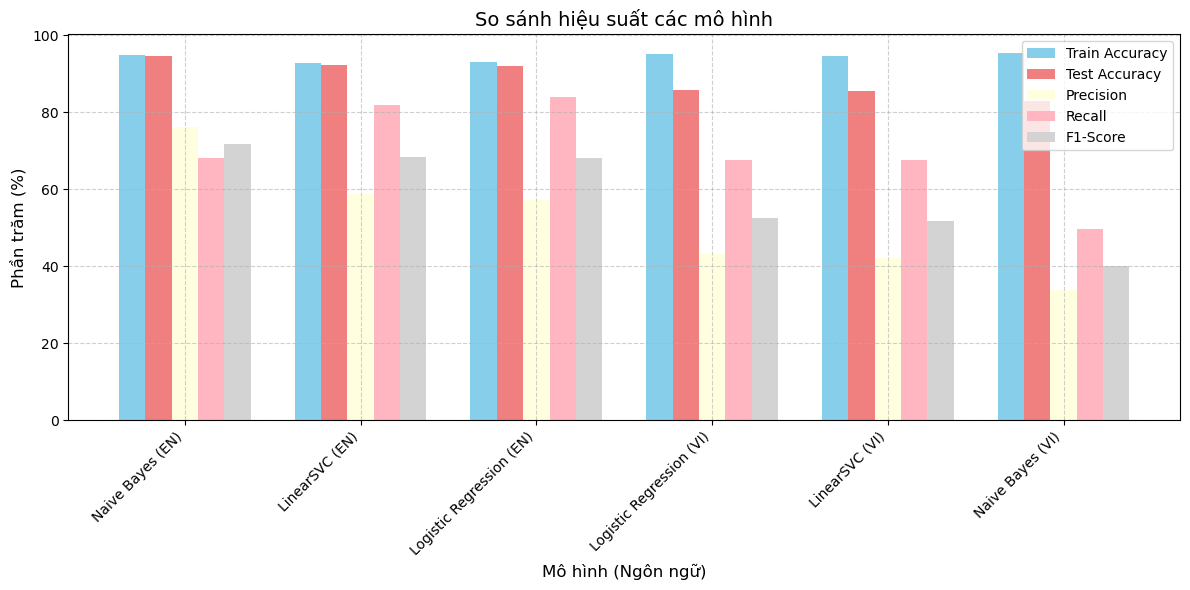

In [19]:
#  TRỰC QUAN HÓA BÀNG SO SÁNH DƯỚI DẠNG BIỂU ĐỒ CỘT


print("\n" + "="*60)
print("TRỰC QUAN HÓA BÀNG SO SÁNH DƯỚI DẠNG BIỂU ĐỒ CỘT")
print("="*60)

# Số lượng mô hình
n_models = len(df_comparison)

# Thiết lập vị trí cho các cột
bar_width = 0.15
index = np.arange(n_models)

# Tạo figure và axes
fig, ax = plt.subplots(figsize=(12, 6))

# Vẽ các cột cho từng chỉ số
ax.bar(index, df_comparison['train_acc'], bar_width, label='Train Accuracy', color='skyblue')
ax.bar(index + bar_width, df_comparison['test_acc'], bar_width, label='Test Accuracy', color='lightcoral')
ax.bar(index + 2 * bar_width, df_comparison['precision'], bar_width, label='Precision', color='lightyellow')
ax.bar(index + 3 * bar_width, df_comparison['recall'], bar_width, label='Recall', color='lightpink')
ax.bar(index + 4 * bar_width, df_comparison['f1'], bar_width, label='F1-Score', color='lightgray')

# Thêm nhãn và tiêu đề
ax.set_xlabel('Mô hình (Ngôn ngữ)', fontsize=12)
ax.set_ylabel('Phần trăm (%)', fontsize=12)
ax.set_title('So sánh hiệu suất các mô hình', fontsize=14)
ax.set_xticks(index + 2 * bar_width)
ax.set_xticklabels(df_comparison['model_name'], rotation=45, ha='right', fontsize=10)
ax.legend(fontsize=10)

# Thêm lưới để dễ đọc
ax.grid(True, linestyle='--', alpha=0.6)

# Điều chỉnh layout để tránh chồng lấn
plt.tight_layout()
plt.show()

In [ ]:

import tkinter as tk
from tkinter import ttk, messagebox

print("\n" + "="*60)
print("HIỂN THỊ CỬA SỔ DIALOG ĐỂ DỰ ĐOÁN")
print("="*60)

# Hàm dự đoán và hiển thị kết quả
def predict_text():
    input_text = text_box.get("1.0", tk.END).strip()
    language = language_var.get()
    
    if not input_text:
        messagebox.showwarning("Cảnh báo", "Vui lòng nhập văn bản!")
        return
    
    if language == "Tiếng Anh":
        models = best_models_en
    elif language == "Tiếng Việt":
        models = best_models_vi
    else:
        messagebox.showerror("Lỗi", "Ngôn ngữ không hợp lệ!")
        return
    
    results = {}
    for model_name, model_info in models.items():
        model = model_info['model']
        # Vector hóa văn bản đầu vào
        if language == "Tiếng Anh":
            vectorizer = tfidf_vectorizer_en
        else:  # Tiếng Việt
            vectorizer = tfidf_vectorizer_vi
        X_input = vectorizer.transform([input_text])
        prediction = model.predict(X_input)[0]
        probability = model.predict_proba(X_input)[0][1] if hasattr(model, 'predict_proba') else None
        results[model_name] = {
            'prediction': "Toxic" if prediction == 1 else "Non-toxic",
            'probability': f"{probability:.2f}" if probability is not None else "N/A"
        }
    
    # Hiển thị kết quả
    result_text.delete("1.0", tk.END)
    result_text.insert(tk.END, f"Kết quả dự đoán cho văn bản: '{input_text}'\n")
    result_text.insert(tk.END, f"Ngôn ngữ: {language}\n\n")
    for model_name, result in results.items():
        result_text.insert(tk.END, f"{model_name}:\n")
        result_text.insert(tk.END, f"  - Dự đoán: {result['prediction']}\n")

# Hàm đóng cửa sổ
def cancel():
    window.destroy()

# Tạo cửa sổ chính
window = tk.Tk()
window.title("Dự đoán văn bản")
window.geometry("500x400")

# Tiêu đề
title_label = tk.Label(window, text="Nhập văn bản để dự đoán", font=("Arial", 14, "bold"))
title_label.pack(pady=10)

# Ô nhập văn bản
text_box = tk.Text(window, height=5, width=50)
text_box.pack(pady=10)

# Chọn ngôn ngữ
language_var = tk.StringVar(value="Tiếng Anh")
language_label = tk.Label(window, text="Chọn ngôn ngữ:")
language_label.pack()
language_menu = ttk.OptionMenu(window, language_var, "Tiếng Anh", "Tiếng Anh", "Tiếng Việt")
language_menu.pack()

# Nút Predict và Cancel
button_frame = tk.Frame(window)
button_frame.pack(pady=10)

predict_button = tk.Button(button_frame, text="Predict", command=predict_text, bg="lightgreen", fg="black")
predict_button.pack(side=tk.LEFT, padx=5)

cancel_button = tk.Button(button_frame, text="Cancel", command=cancel, bg="salmon", fg="black")
cancel_button.pack(side=tk.LEFT, padx=5)

# Khu vực hiển thị kết quả
result_label = tk.Label(window, text="Kết quả:", font=("Arial", 12))
result_label.pack(pady=10)
result_text = tk.Text(window, height=10, width=50)
result_text.pack(pady=10)

# Chạy ứng dụng
window.mainloop()


HIỂN THỊ CỬA SỔ DIALOG ĐỂ DỰ ĐOÁN
